In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV


In [3]:
# Step 1: Load the Dataset
df = pd.read_csv('sentimentdataset.csv')

# Ensure dataset has 'text' and 'sentiment' columns
if 'Text' not in df.columns or 'Sentiment' not in df.columns:
    raise ValueError("Dataset must contain 'text' and 'sentiment' columns.")


In [6]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,cleaned_text
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12,enjoying a beautiful day at the park
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8,traffic was terrible this morning
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15,just finished an amazing workout
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18,excited about the upcoming weekend getaway
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19,trying out a new recipe for dinner tonight


In [4]:
# Step 2: Preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text


In [5]:
df['cleaned_text'] = df['Text'].apply(preprocess_text)


In [7]:

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [11]:
# Handle class imbalance
majority_class = df[df['Sentiment'] == df['Sentiment'].mode()[0]]
minority_classes = [df[df['Sentiment'] == cls] for cls in df['Sentiment'].unique() if cls != df['Sentiment'].mode()[0]]


In [12]:
resampled_minority_classes = [resample(cls, replace=True, n_samples=len(majority_class), random_state=42) for cls in minority_classes]
df_balanced = pd.concat([majority_class] + resampled_minority_classes)


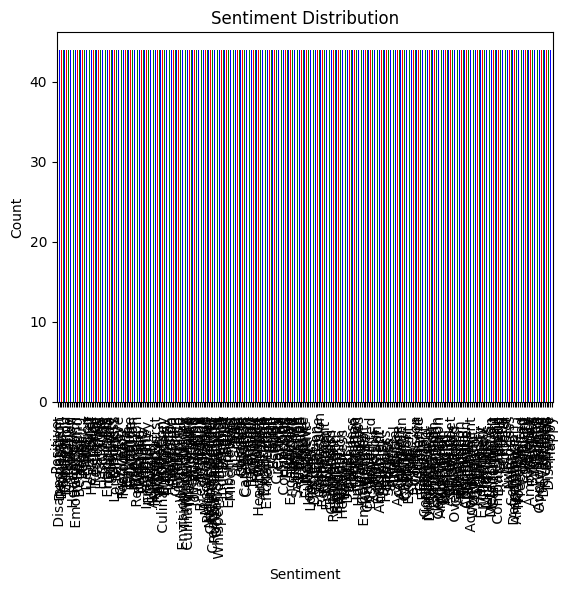

In [14]:
# Step 3: Visualizations
# Plot sentiment distribution
sentiment_counts = df_balanced['Sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [15]:
# # Generate word clouds for each sentiment
# for sentiment in df_balanced['Sentiment'].unique():
#     sentiment_text = ' '.join(df_balanced[df_balanced['sentiment'] == sentiment]['cleaned_text'])
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)
#     plt.figure()
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f'Word Cloud for {sentiment} Sentiment')
#     plt.show()

In [16]:
# Step 4: Feature Extraction and Model Training
X = df_balanced['cleaned_text']
y = df_balanced['Sentiment']


In [17]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Compare Bag of Words (BoW) and TF-IDF
vectorizers = {
    'BoW': CountVectorizer(ngram_range=(1, 2)),
    'TF-IDF': TfidfVectorizer(ngram_range=(1, 2))
}

In [19]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [20]:


for vec_name, vectorizer in vectorizers.items():
    print(f"\nUsing {vec_name} features:")
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Dimensionality reduction
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_train_vec = svd.fit_transform(X_train_vec)
    X_test_vec = svd.transform(X_test_vec)

    for model_name, model in models.items():
        # Hyperparameter tuning for Logistic Regression
        if model_name == 'Logistic Regression':
            params = {'C': [0.01, 0.1, 1, 10]}
            grid = GridSearchCV(model, params, cv=5)
            grid.fit(X_train_vec, y_train)
            model = grid.best_estimator_

        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        print(f"\nModel: {model_name}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(classification_report(y_test, y_pred))


Using BoW features:

Model: Logistic Regression
Accuracy: 0.99
                        precision    recall  f1-score   support

         Acceptance          0.90      1.00      0.95         9
      Acceptance             1.00      1.00      1.00        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           1.00      1.00      1.00         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        1.00      1.00      1.00        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model: SVM
Accuracy: 0.93
                        precision    recall  f1-score   support

         Acceptance          0.90      1.00      0.95         9
      Acceptance             1.00      1.00      1.00        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           0.57      1.00      0.73         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        1.00      0.71      0.83        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      1.00      1.00        10
        Amus

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model: KNN
Accuracy: 0.98
                        precision    recall  f1-score   support

         Acceptance          0.90      1.00      0.95         9
      Acceptance             1.00      1.00      1.00        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           1.00      1.00      1.00         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        1.00      1.00      1.00        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      1.00      1.00        10
        Amus

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model: Gradient Boosting
Accuracy: 0.98
                        precision    recall  f1-score   support

         Acceptance          1.00      1.00      1.00         9
      Acceptance             1.00      1.00      1.00        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           1.00      1.00      1.00         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        1.00      1.00      1.00        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      1.00      1.00        1

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model: Logistic Regression
Accuracy: 0.94
                        precision    recall  f1-score   support

         Acceptance          0.70      0.78      0.74         9
      Acceptance             0.83      1.00      0.91        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           1.00      1.00      1.00         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        0.90      0.64      0.75        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      1.00      1.00       

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Model: SVM
Accuracy: 0.92
                        precision    recall  f1-score   support

         Acceptance          0.88      0.78      0.82         9
      Acceptance             0.83      1.00      0.91        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           1.00      1.00      1.00         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        1.00      0.64      0.78        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      1.00      1.00        10
        Amus

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                        precision    recall  f1-score   support

         Acceptance          0.90      1.00      0.95         9
      Acceptance             1.00      1.00      1.00        10
       Accomplishment        1.00      1.00      1.00         8
           Admiration        1.00      1.00      1.00         8
         Admiration          1.00      1.00      1.00        10
        Admiration           1.00      1.00      1.00         6
         Adoration           1.00      1.00      1.00         8
       Adrenaline            1.00      1.00      1.00         2
            Adventure        1.00      1.00      1.00        14
         Affection           1.00      1.00      1.00        10
            Amazement        1.00      1.00      1.00         8
          Ambivalence        1.00      1.00      1.00        11
      Ambivalence            1.00      1.00      1.00         5
         Amusement           1.00      1.00      1.00        10
        Amusement            1.00      

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [21]:
import joblib

# Save the best model and vectorizer
best_model = LogisticRegression(max_iter=1000, C=1)  
best_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_vec = best_vectorizer.fit_transform(X_train)
best_model.fit(X_train_vec, y_train)

joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(best_vectorizer, 'vectorizer.pkl')

# Function to predict sentiment
def predict_sentiment(text):
    model = joblib.load('sentiment_model.pkl')
    vectorizer = joblib.load('vectorizer.pkl')

    # Preprocess text
    text_cleaned = preprocess_text(text)
    text_vec = vectorizer.transform([text_cleaned])
    
    # Predict
    sentiment = model.predict(text_vec)
    return sentiment[0]

# Test the prediction function
test_text = "I love this product! It works great."
predicted_sentiment = predict_sentiment(test_text)
print(f"Predicted Sentiment: {predicted_sentiment}")


Predicted Sentiment:  Excitement 
